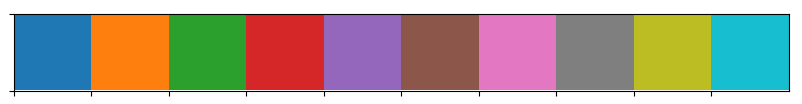

In [15]:
import matplotlib.pyplot as plt
import setuptools
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
from IPython.display import HTML
from qutip import *

%matplotlib inline
plt.style.use('default')
plt.style.use('seaborn-paper')
current_palette = sns.color_palette(palette=None)
sns.set_palette(palette=None)
sns.palplot(current_palette)

mpl.rcParams.update({'figure.figsize': (5, 4)})
mpl.rcParams['figure.dpi']= 150

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


[ 1.          2.99997449  4.99989797  6.99977042]


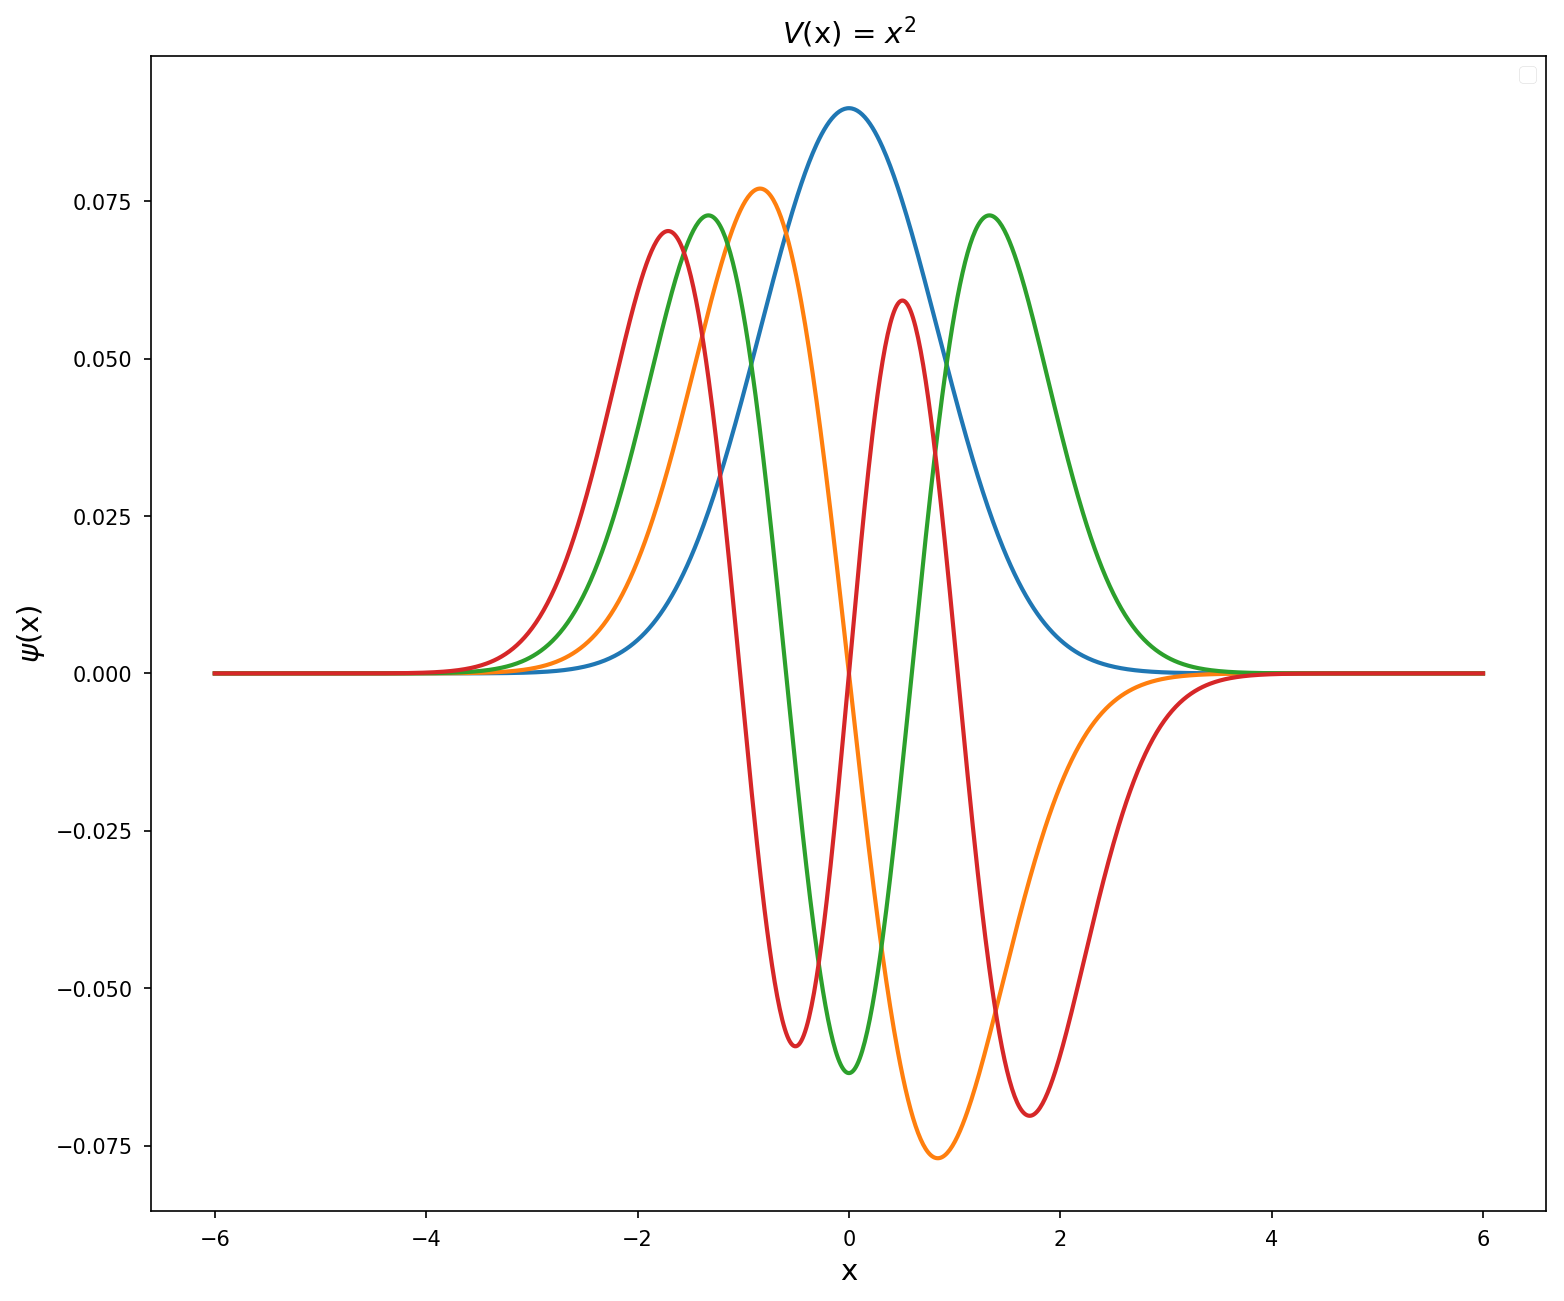

In [10]:
def Vpot(x):
    return x**2

a = -6
b = 6
N = 1000

x = np.linspace(a,b,N)
h = x[1]-x[0]

T = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0

V = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
H = -T/(2*h**2) + V
val,vec=np.linalg.eig(H)
z = np.argsort(val)
z = z[0:4]
energies=(val[z]/val[z][0])

print(energies)

plt.figure(figsize=(12,10))
for i in range(len(z)):
    y = []
    y = np.append(y,vec[:,z[i]])
    y = np.append(y,0)
    y = np.insert(y,0,0)
    plt.plot(x,y,lw=2, label='')
    plt.xlabel('x', size=14)
    plt.ylabel('$\psi$(x)',size=14)
plt.legend()
plt.title('$V$(x) = $x^2$',size=14)
plt.show()

# The Charge Superconducting Qubit

[ 1.]


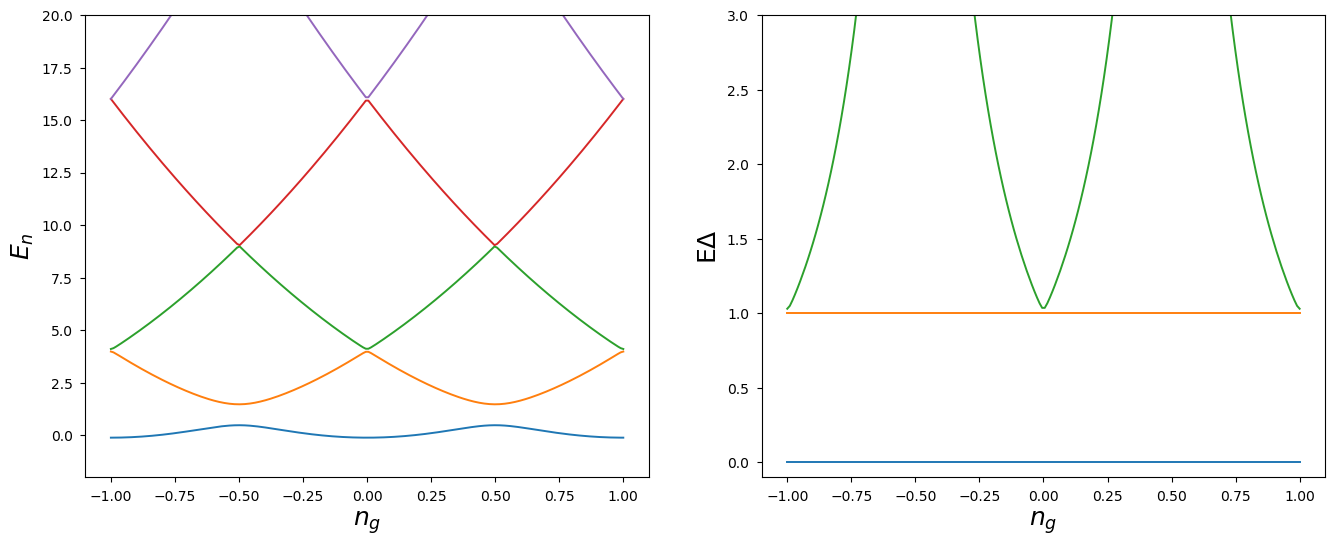

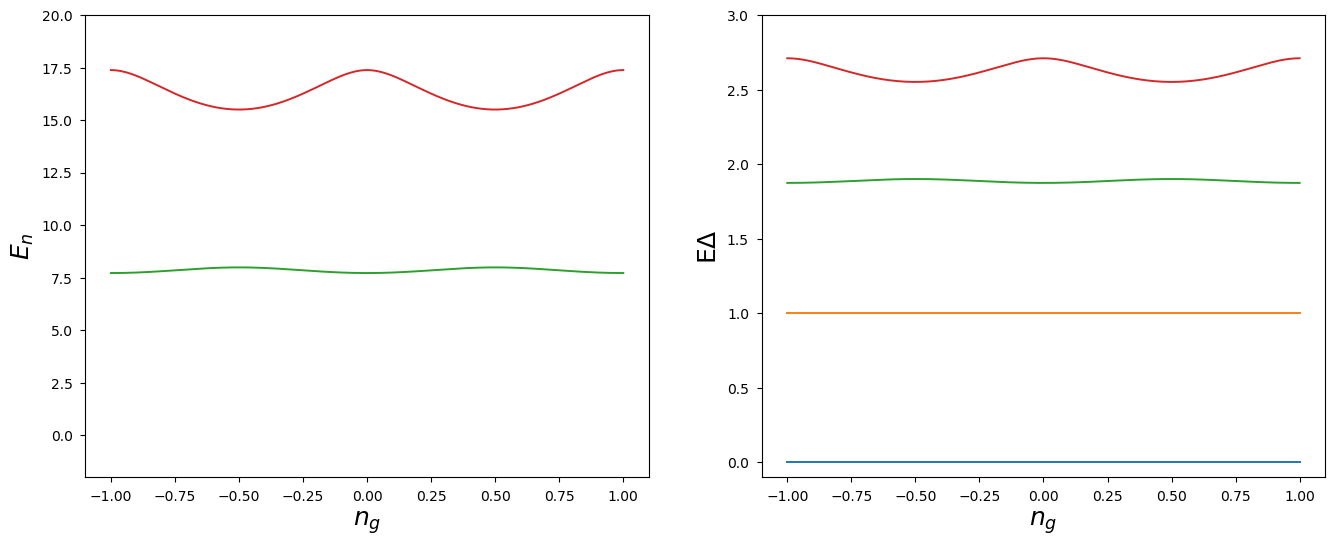

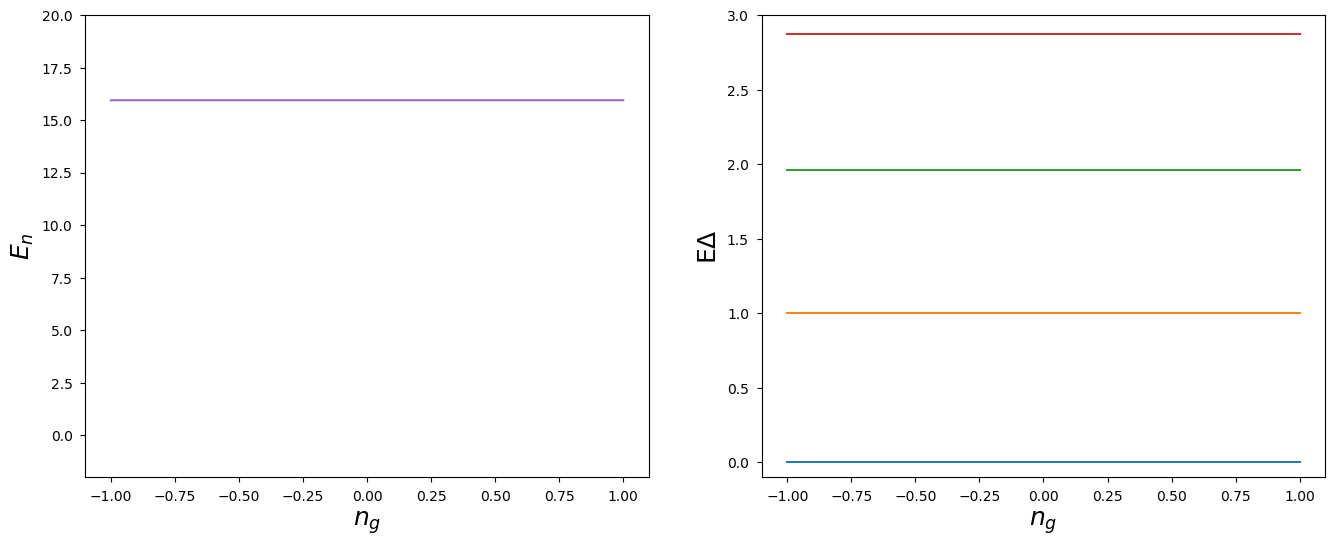

In [11]:
def hamiltonian(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + 
                                                               np.diag(-np.ones(2*N), -1))
    return Qobj(m)

def plot_energies(ng_vec, energies, ymax=(20, 3)):
    """
    Plot energy levels as a function of bias parameter ng_vec.
    """
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    for n in range(len(energies[0,:])):
        axes[0].plot(ng_vec, energies[:,n])
    axes[0].set_ylim(-2, ymax[0])
    axes[0].set_xlabel(r'$n_g$', fontsize=18)
    axes[0].set_ylabel(r'$E_n$', fontsize=18)

    for n in range(len(energies[0,:])):
        axes[1].plot(ng_vec, (energies[:,n]-energies[:,0])/(energies[:,1]-energies[:,0]))
    axes[1].set_ylim(-0.1, ymax[1])
    axes[1].set_xlabel(r'$n_g$', fontsize=18)
#     axes[1].set_ylabel(r'$(E_n-E_0)/(E_1-E_0)$', fontsize=18)
    axes[1].set_ylabel(r'E$\Delta$', fontsize=18)
    return fig, axes

def visualize_dynamics(result, ylabel):
    """
    Plot the evolution of the expectation values stored in result.
    """
    fig, ax = plt.subplots(figsize=(12,5))

    ax.plot(result.times, result.expect[0])

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(r'$t$', fontsize=16);
    
N = 10
Ec = 1.0
Ej_arr = [1, 20, 100]

ng_vec = np.linspace(-1, 1, 200)
for Ej in Ej_arr:
    energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies() for ng in ng_vec])
    plot_energies(ng_vec, energies);
    

print(np.linspace(1,10,1))

# Ideal Resonator - Qubit Interaction

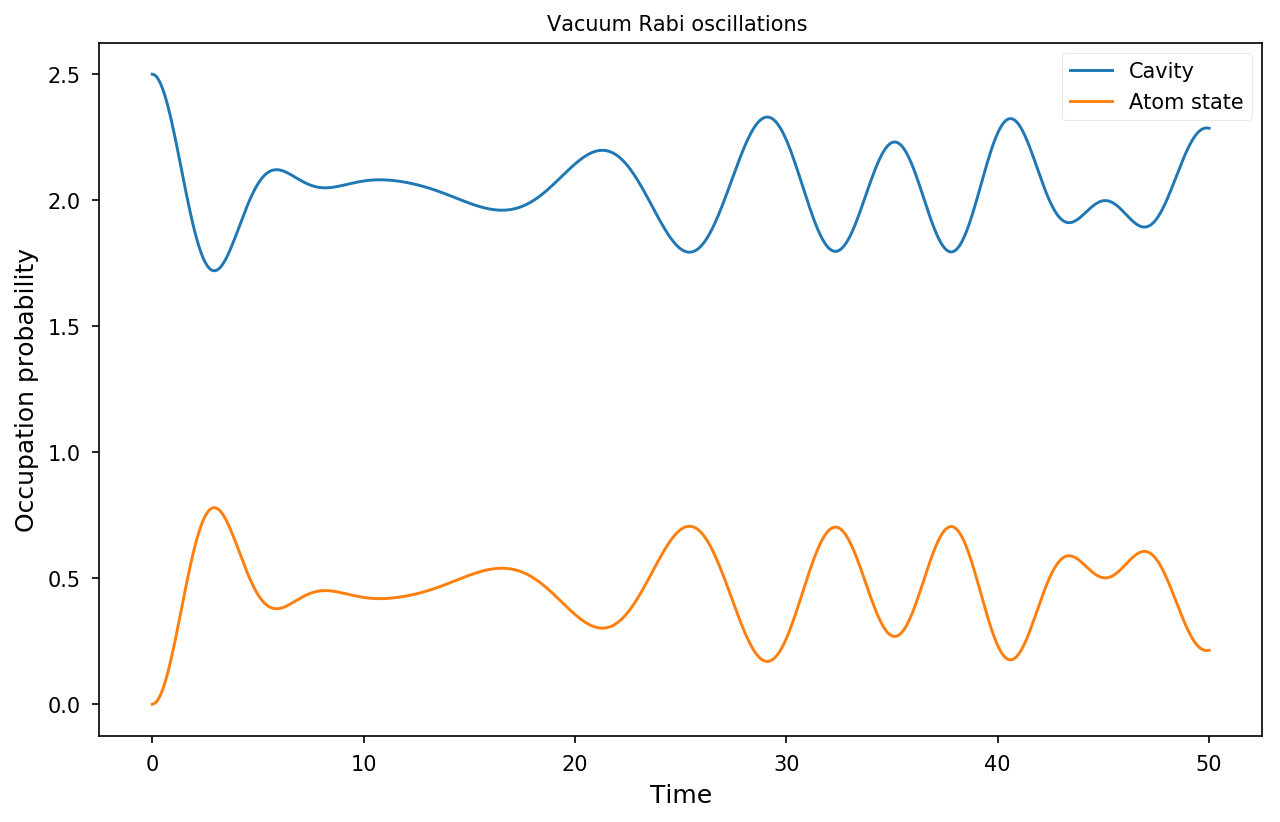

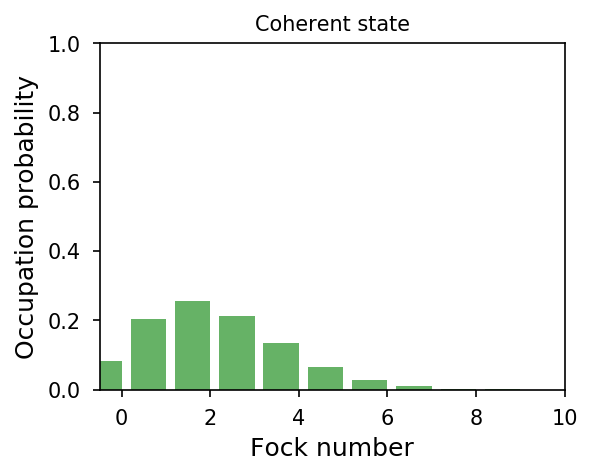

In [16]:
wd = 1.0 * 2 * np.pi   # Driving frequency [Hz]
wr = 1.0 * 2 * np.pi   # Resonator Frequency [Hz]
w10 = 1.0 * 2* np.pi # qubit 1 --> 0 frequency

g = 0.05 * 2 * np.pi # coupling energy
N = 10 # number of fock state initialization max

#define operators
a = tensor(destroy(N), qeye(2)) #define the annihlation operator of the resonator, (resonator is first tensor product)
sm = tensor(qeye(N), destroy(2)) # sigma minus, annihlation operator of the qubit
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
I = tensor(qeye(N), qeye(2))


tlist = np.linspace(0,50,501) # time samples

H = wr*(a.dag()*a + I/2.0) - sz*w10*1/2 + g*(a.dag()*sm + a*sm.dag())


# state initialization

Cohr_state = coherent(N,np.sqrt(2.5)); #n_avg = |\alpha|^2

psi0 = tensor(Cohr_state, basis(2,0))  # Tensor of the Basis of the cavity and the atom with the cavity at Nth state, and basis at 0th state

c_ops = []

output = mesolve(H, psi0, tlist, c_ops, [a.dag()*a, sm.dag()*sm, a])

n_c = output.expect[0] # First output of the mesolve [], and so on
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations ')


# Coherent states
fig, ax = plt.subplots(figsize=(4, 3))
plot_fock_distribution(Cohr_state, fig=fig, ax=ax, title="Coherent state");

## Notes on Cavity resonant Jaynes-Cumming Hamiltonian

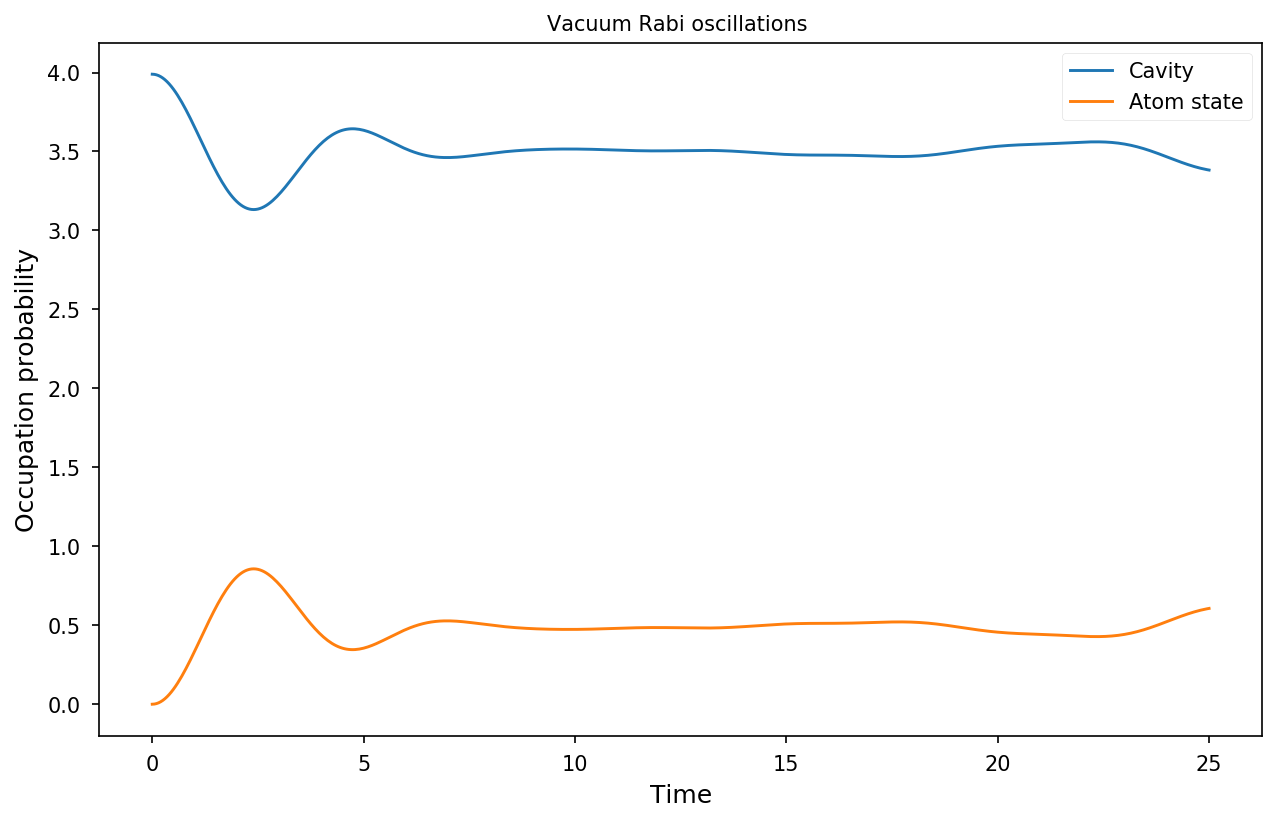

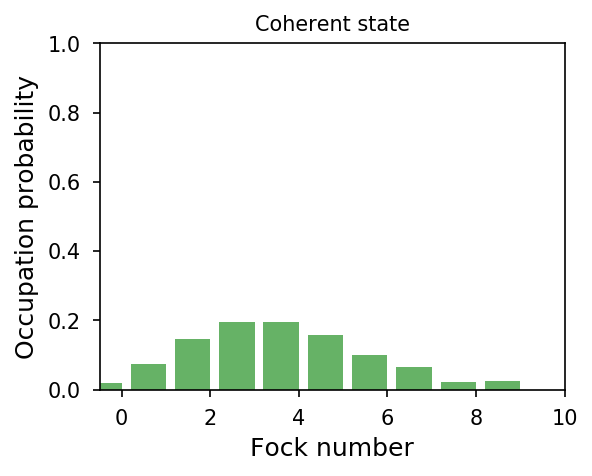

In [13]:
wd = 1.0 * 2 * np.pi   # Driving frequency [Hz]
wr = 1.0 * 2 * np.pi   # Resonator Frequency [Hz]
w10 = 1.0 * 2* np.pi # qubit 1 --> 0 frequency

g = 0.05 * 2 * np.pi # coupling energy
N = 10 # number of fock state initialization max

#define operators
a = tensor(destroy(N), qeye(2)) #define the annihlation operator of the resonator, (resonator is first tensor product)
sm = tensor(qeye(N), destroy(2)) # sigma minus, annihlation operator of the qubit
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
I = tensor(qeye(N), qeye(2))


tlist = np.linspace(0,25,501) # time samples

H = wr*(a.dag()*a + I/2.0) - sz*w10*1/2 + g*(a.dag()*sm + a*sm.dag())


# state initialization

Cohr_state = coherent(N,np.sqrt(4)); #n_avg = |\alpha|^2

psi0 = tensor(Cohr_state, basis(2,0))  # Tensor of the Basis of the cavity and the atom with the cavity at Nth state, and basis at 0th state

c_ops = []


output = mesolve(H, psi0, tlist, c_ops, [a.dag()*a, sm.dag()*sm, 1/np.sqrt(2)*(a+a.dag()), 1/np.sqrt(2)*(a-a.dag())])

n_c = output.expect[0]# First output of the mesolve [], and so on
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations ')


# Coherent states
fig, ax = plt.subplots(figsize=(4, 3))
plot_fock_distribution(Cohr_state, fig=fig, ax=ax, title="Coherent state");

# Resonator Driven by a Source

C:\Anaconda_Pack\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Bagas Prabowo\Documents\git\Superconducting Qubit\rhs191620.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Text(0.5,1,'Occupation Probability with Drive')

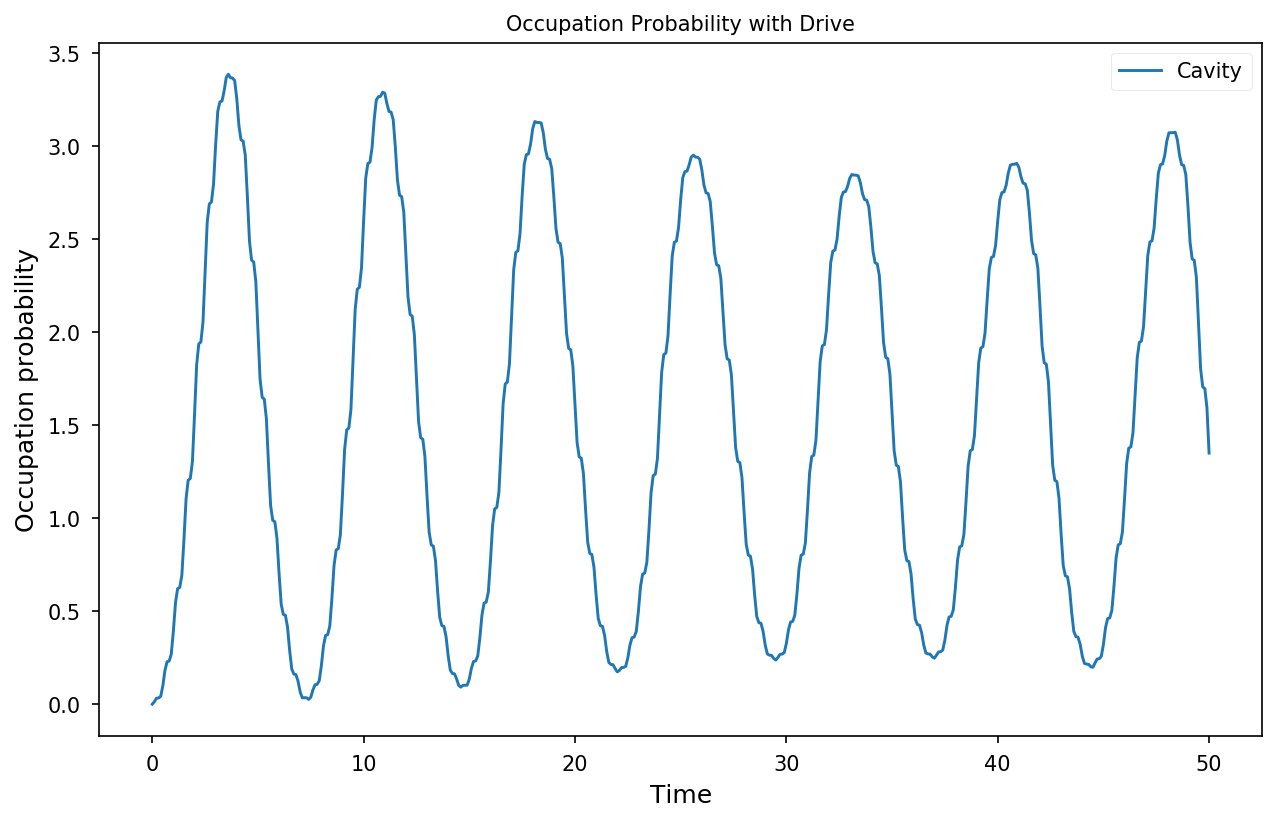

In [30]:
wd = 1 * 2 * np.pi   # Driving frequency [Hz]
wr = 1.0 * 2 * np.pi   # Resonator Frequency [Hz]
w10 = 1.0 * 2* np.pi # qubit 1 --> 0 frequency

g = 0.05 * 2 * np.pi # coupling energy
N = 5 # number of fock state initialization max

#define operators
a = destroy(N) #define the annihlation operator of the resonator, (resonator is first tensor product)
I = qeye(N)

C_couple = 0.2 * 2 * np.pi # Coupling constant between driver and resonator

tlist = np.linspace(0,50,501) # time samples

#Hamiltonian

H0 = wr*(a.dag()*a + I/2.0) 
Hd = C_couple*(a.dag() + a)
Heff = [H0, [Hd, 'cos(wd*t)']]
args = {'wd': wd}

# state initialization

Cohr_state = coherent(N,np.sqrt(0)); #n_avg = |\alpha|^2


c_ops = []


output = mesolve(Heff, Cohr_state, tlist, c_ops, [a.dag()*a], args=args)

n_c = output.expect[0]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, n_c, label="Cavity")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Occupation Probability with Drive')


# Coherent states
# fig, ax = plt.subplots(figsize=(4, 3))
# plot_fock_distribution(Cohr_state, fig=fig, ax=ax, title="Coherent state");




# Dynamics of Transmon driven Qubit

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]


C:\Anaconda_Pack\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Bagas Prabowo\Documents\git\Superconducting Qubit\rhs19168.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Anaconda_Pack\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Bagas Prabowo\Documents\git\Superconducting Qubit\rhs19169.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


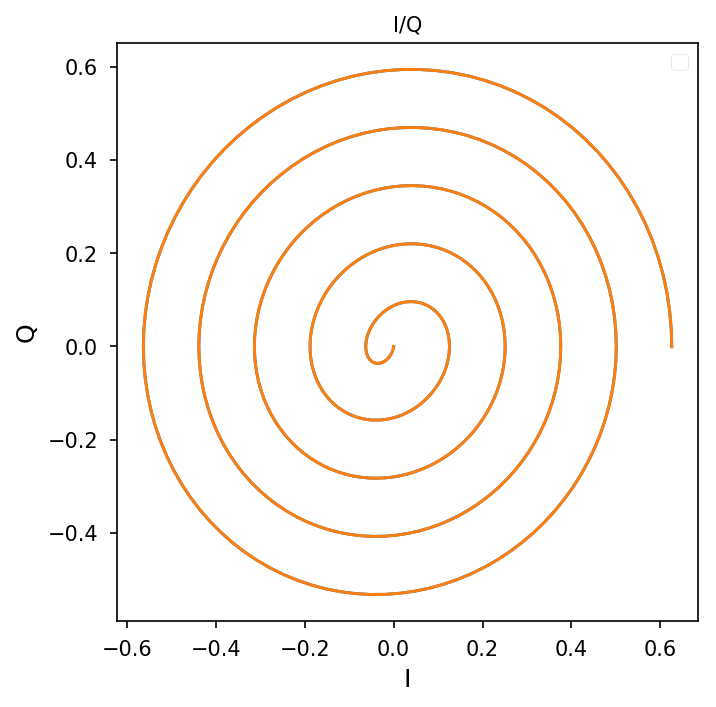

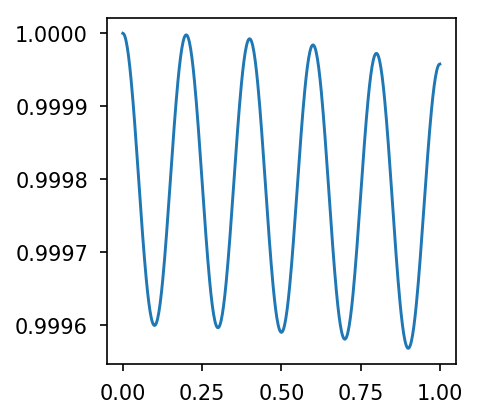

In [18]:
wd = 5 * 2 * np.pi   # Driving frequency [Hz]
wr = 5 * 2 * np.pi   # Resonator Frequency [Hz]
w10 = 10 * 2* np.pi # qubit 1 --> 0 frequency

g = 0.05 * 2 * np.pi # coupling energy
N = 30 # number of fock state initialization max

kappa_r = 0.015

#define operators
a = tensor(destroy(N), qeye(2)) #define the annihlation operator of the resonator, (resonator is first tensor product)
sm = tensor(qeye(N), destroy(2)) # sigma minus, annihlation operator of the qubit
sz = tensor(qeye(N), sigmaz())
I = tensor(qeye(N), qeye(2))

print(sigmaz())
tlist = np.linspace(0,1,501) # time samples
C_couple = 0.2* 2 * np.pi # Coupling constant between driver and resonator


H0 = wr*(a.dag()*a + I/2.0) - sz*w10*1/2 - g*(a.dag()*sm + a*sm.dag())
Hd = C_couple*(a.dag() + a)
Heff = [H0, [Hd, 'sin(wd*t)']]
args = {'wd': wd}


# state initialization

Cohr_state = coherent(N,np.sqrt(0)); #n_avg = |\alpha|^2

psi_g = tensor(basis(N,0), basis(2,0))  # Tensor of the Basis of the cavity and the atom with the cavity at Nth state, and basis at 0th state
psi_e = tensor(basis(N,0), basis(2,1))  
c_ops = [np.sqrt(kappa_r)*a]



output_1 = mesolve(Heff, psi_g, tlist, c_ops, [a.dag()*a, sm.dag()*sm, a, a.dag()], args=args)
output_2 = mesolve(Heff, psi_e, tlist, c_ops, [a.dag()*a, sm.dag()*sm, a, a.dag()], args=args)



out_g_I = np.real(output_1.expect[2])
out_g_Q = np.imag(output_1.expect[2])

out_e_I = np.real(output_2.expect[2])
out_e_Q = np.imag(output_2.expect[2])




fig, axes = plt.subplots(1, 1, figsize=(5,5))


axes.plot(out_g_I, out_g_Q)
axes.plot(out_e_I, out_e_Q)

axes.legend(loc=0)
axes.set_xlabel('I')
axes.set_ylabel('Q')
axes.set_title('I/Q')


# Coherent states
fig, ax = plt.subplots(figsize=(3, 3))
n_avg = output_2.expect[1]

ax.plot(tlist, n_avg)